# First Model for New Data

August 22, 2024

In [1]:
import sys
import os

myhost = os.uname()[1]
print("Running on Computer: [%s]" %myhost)

sys.path.insert(0, '/home/ifernand/Code/') 
dirname = '/home/ifernand/Cloud_SynthData_Proj'

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import io as sio
import torch
import time
import h5py

# NDN tools
import NDNT
import NDNT.utils as utils
from NDNT.modules.layers import *
from NDNT.networks import *
import NDNT.NDN as NDN
from NTdatasets.conway.synthcloud_datasets import SimCloudData
from NTdatasets.generic import GenericDataset
from ColorDataUtils.multidata_utils import MultiExperiment
import ColorDataUtils.ConwayUtils as CU
from ColorDataUtils import readout_fit
from ColorDataUtils.simproj_utils import *
from NDNT.utils import fit_lbfgs, fit_lbfgs_batch
from NDNT.utils import imagesc   
from NDNT.utils import ss

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

%load_ext autoreload
%autoreload 2

Running on Computer: [sc]
Invoking __init__.py for NDNT.utils


## Load Data

In [2]:
out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3.hdf5'
with h5py.File(out_file, 'r') as f:
    x_pos = f['x_pos'][:]
    y_pos = f['y_pos'][:]
    cell_key = [str(f['cell_key'][:][i], encoding='utf-8') for i in range(x_pos.shape[0])]
    file_start_pos = list(f['file_start_pos'][:])

In [3]:
# cell specific indices
LGN_idx = [i for i, val in enumerate(cell_key) if val == 'X_ON' or val == 'X_OFF']
V1_idx  = [i for i, val in enumerate(cell_key) if val == 'V1_Exc_L4' or val == 'V1_Inh_L4' or val == 'V1_Exc_L2/3' or val == 'V1_Inh_L2/3']
L23_idx = [i for i, val in enumerate(cell_key) if val == 'L23_exc' or val == 'L23_inh']
L23_exc_idx = [i for i, val in enumerate(cell_key) if val == 'L23_exc']
L23_inh_idx = [i for i, val in enumerate(cell_key) if val == 'L23_inh']
L4_idx  = [i for i, val in enumerate(cell_key) if val == 'L4_exc' or val == 'L4_inh']
L4_exc_idx = [i for i, val in enumerate(cell_key) if val == 'L4_exc']
L4_inh_idx = [i for i, val in enumerate(cell_key) if val == 'L4_inh']
print('LGN cells:', len(LGN_idx))
print('V1 cells:', len(V1_idx))

LGN cells: 214
V1 cells: 1491


## Data Class

In [4]:
#out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3.hdf5'
start    = time.time()
data     = SimCloudData(file_name=out_file, down_sample=2, cell_idx=V1_idx)
end      = time.time()
print('CPU Time', end-start, 'sec')

CPU Time 53.205477714538574 sec


In [5]:
stim_dims = data.stim_dims
num_lags = data.num_lags
L  = stim_dims[1]
print('stim_dims =', stim_dims)
print('num_lags =', num_lags)
print('L =', L)

stim_dims = [1, 60, 60, 1]
num_lags = 12
L = 60


In [6]:
NC = data[0]['robs'].shape[1]
print('Number of cells', NC)

Number of cells 1491


In [7]:
NT = data.NT
print('Number of time points', NT)

Number of time points 510000


In [8]:
pxl_x_pos, pxl_y_pos = deg2pxl(x_pos[V1_idx], y_pos[V1_idx], L, down_sample=2)
mu0s = utils.pixel2grid(np.stack((pxl_x_pos,pxl_y_pos),axis=1), L=L)
print('Spatial mu0:', mu0s.shape)

Spatial mu0: (1491, 2)


## STA

In [8]:
robs = data[:]['robs']*data[:]['dfs']
nspks = torch.sum(robs,axis=0)

In [13]:
sta_arr = np.zeros((num_lags,L,L,NC))
for j in range(num_lags):
    if j == 0:
        sta = (data[:]['stim'].T @ robs)
    else:
        sta = (data[:]['stim'][:-j, ...].T @ robs[j:,:])
    sta_arr[j,:,:,:] = (sta/nspks).reshape([L,L,NC]).detach().cpu().numpy()

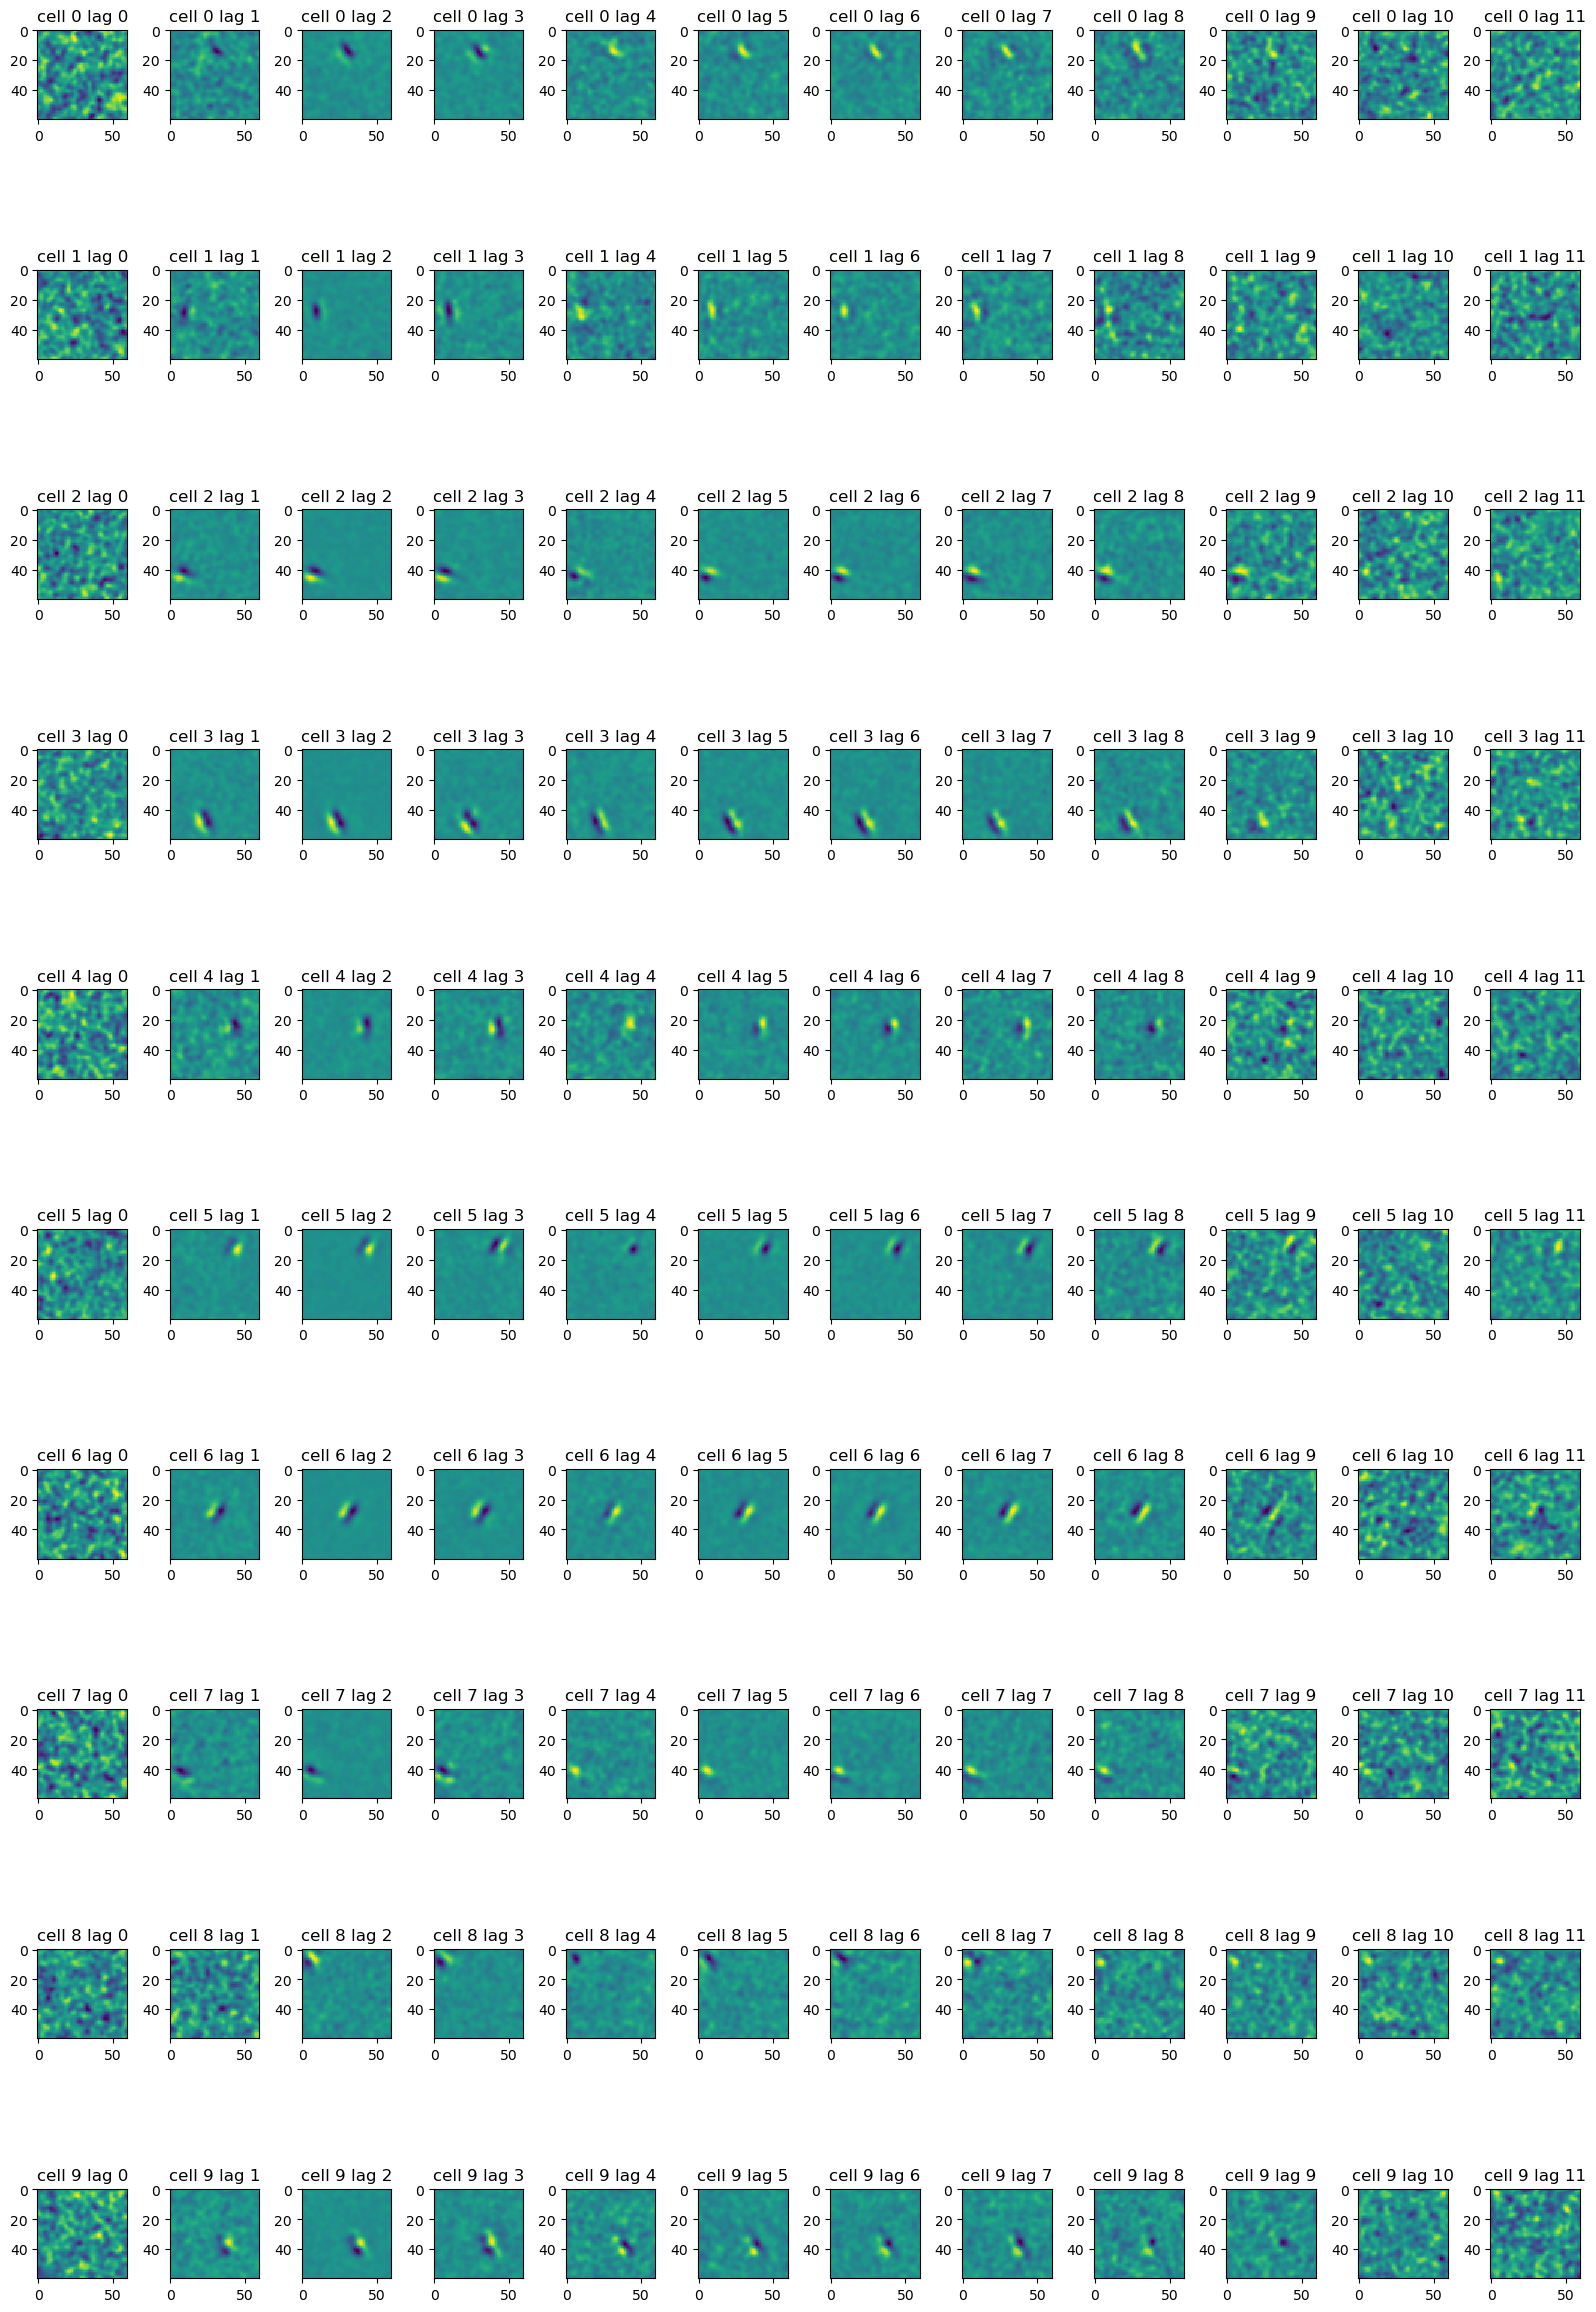

In [16]:
cc = 10
ss(cc,12)
k = 1
for i in range(cc):
    for j in range(12):
        plt.subplot(cc,12,k)
        imagesc(sta_arr[j,:,:,i])
        plt.title('cell '+str(i)+' lag '+str(j))
        k += 1
plt.tight_layout()
plt.show()

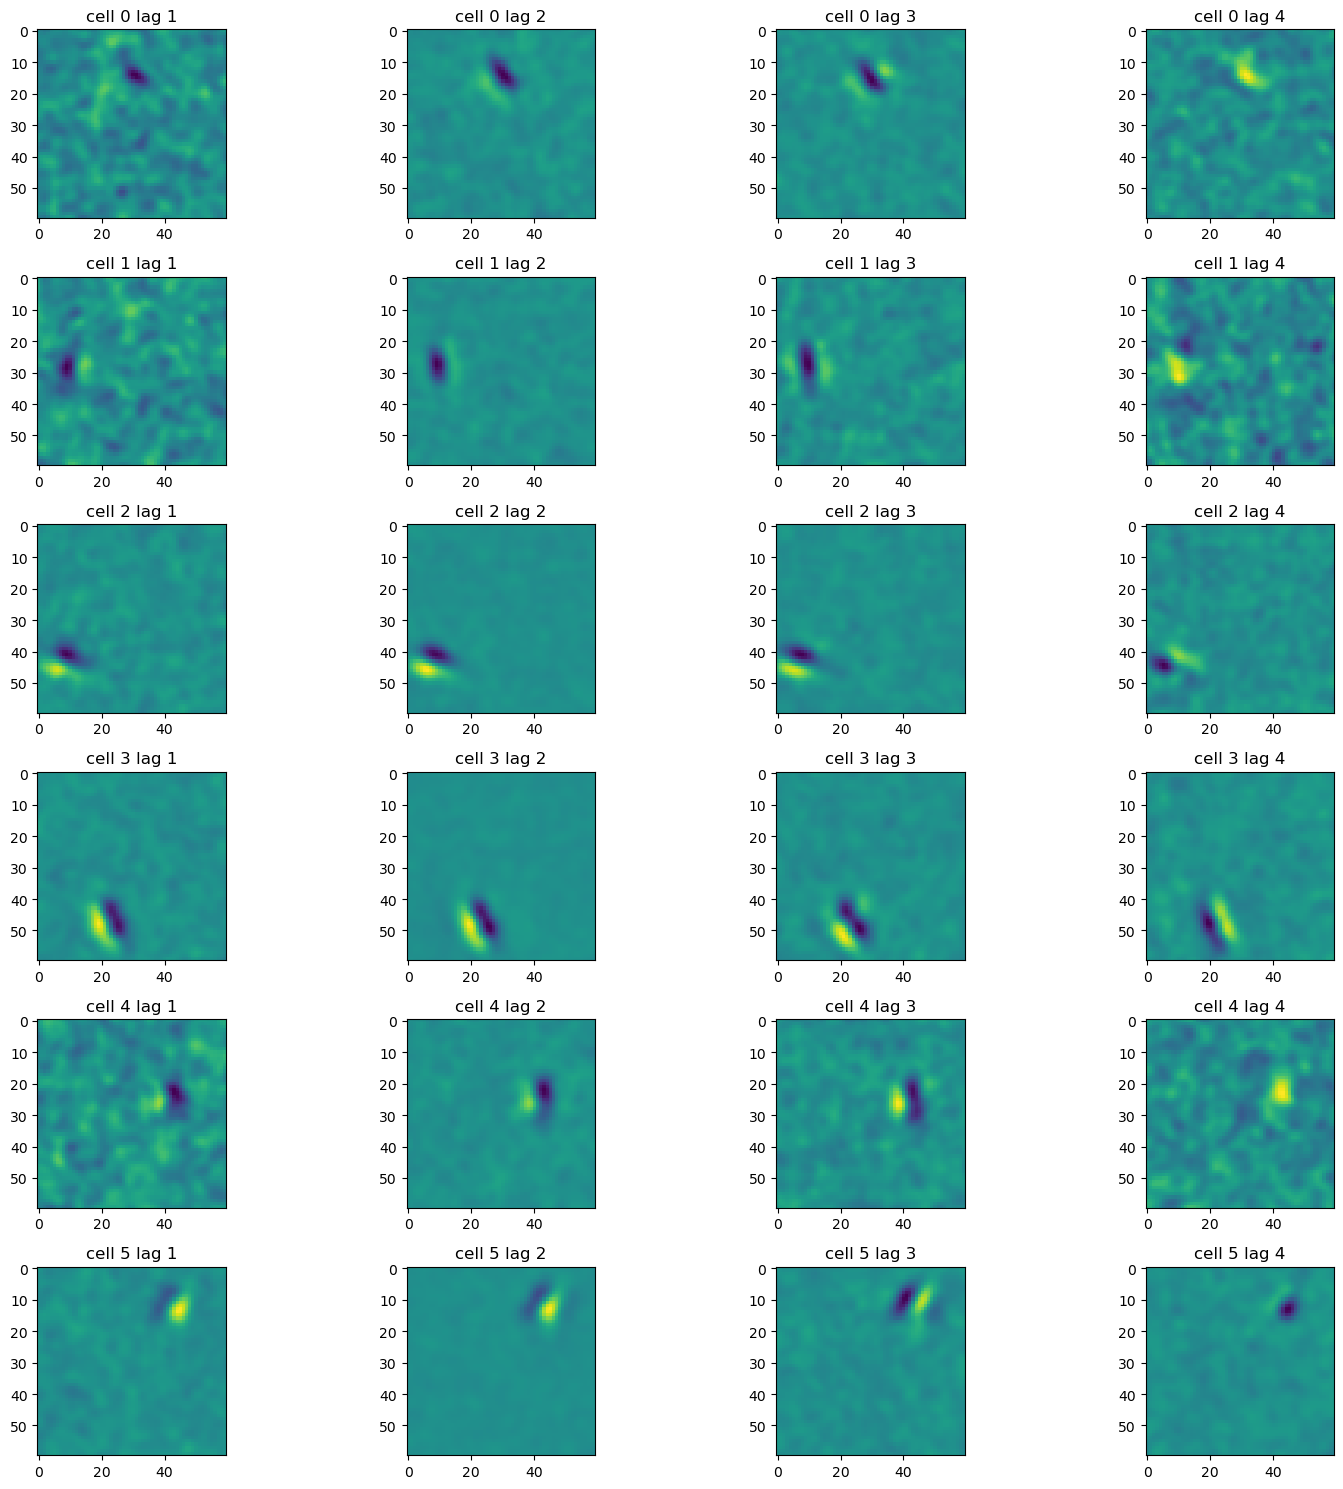

In [19]:
cc = 6
ss(cc,4)
k = 1
for i in range(cc):
    for j in range(1,5):
        plt.subplot(cc,4,k)
        imagesc(sta_arr[j,:,:,i])
        plt.title('cell '+str(i)+' lag '+str(j))
        k += 1
plt.tight_layout()
plt.show()

In [33]:
# TO DO: change to pixle space
V1_y_pos = (x_pos[V1_idx]*10)+L//2
V1_x_pos = -1*((y_pos[V1_idx]*10)+L//2)+L
V1_ori   = ori[V1_idx]

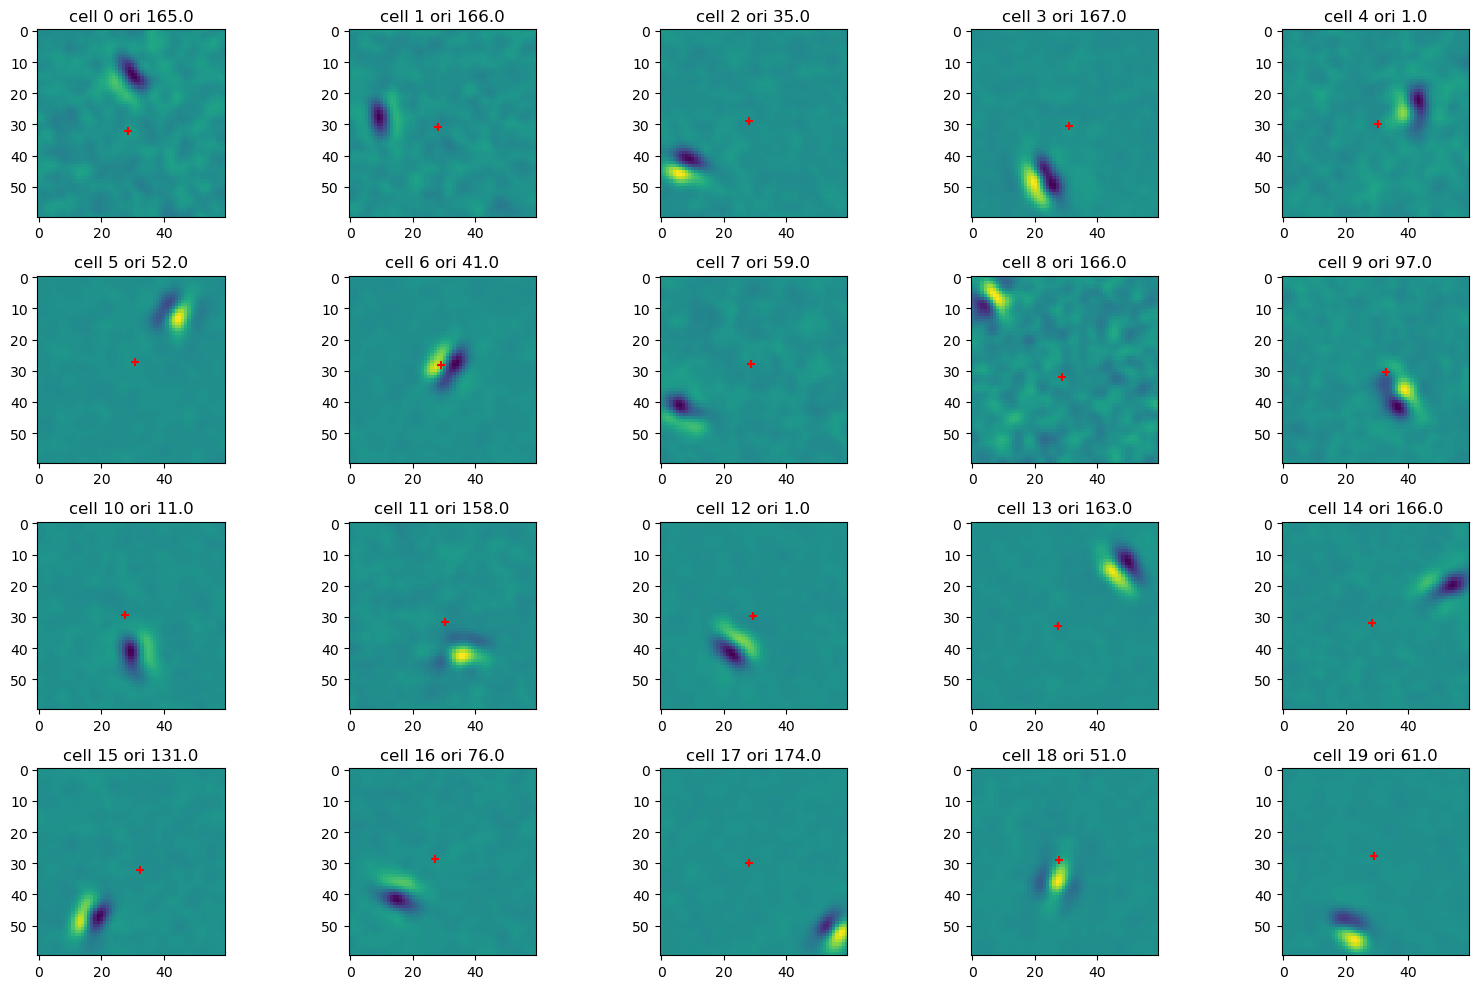

In [34]:
ss(4,5)
k = 1
for i in range(20):
    plt.subplot(4,5,i+1)
    imagesc(sta_arr[2,:,:,i])
    plt.scatter(V1_x_pos[i],V1_y_pos[i],c='r',s=40,marker='+')
    plt.title('cell '+str(i)+' ori '+str(np.round((180/np.pi)*V1_ori[i])))
plt.tight_layout()

## GLM

In [13]:
Treg = 1
Xreg = 10000.0
L1reg = 1.0
GLreg = 10.0

glm_par = Tlayer.layer_dict( 
    input_dims=data.stim_dims, num_filters=NC, bias=True, num_lags=data.num_lags, norm_type=0,
    NLtype='softplus', initialize_center=True)
glm_par['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10} 

glm = NDN( layer_list=[glm_par], loss_type='poisson')
glm.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([43200, 10])
      bias: torch.Size([10])


In [14]:
glm = glm.to(device)
fit_lbfgs(glm, data[:], verbose=True)
glm = glm.to(device0)

Iteration: 0 | Loss: 0.8419547080993652
Iteration: 1 | Loss: 0.8403301239013672
Iteration: 1 | Loss: 0.8261598348617554
Iteration: 1 | Loss: 0.7287380695343018
Iteration: 2 | Loss: 0.6762744188308716
Iteration: 3 | Loss: 0.6464005708694458
Iteration: 4 | Loss: 0.6242513656616211
Iteration: 5 | Loss: 0.5371630191802979
Iteration: 6 | Loss: 0.4623411297798157
Iteration: 7 | Loss: 0.3711909055709839
Iteration: 8 | Loss: 0.29766950011253357
Iteration: 9 | Loss: 0.252692312002182
Iteration: 10 | Loss: 0.23307548463344574
Iteration: 11 | Loss: 0.22345924377441406
Iteration: 12 | Loss: 0.21627582609653473
Iteration: 13 | Loss: 0.21284550428390503
Iteration: 14 | Loss: 0.21095038950443268
Iteration: 15 | Loss: 0.21007248759269714
Iteration: 16 | Loss: 0.2093385010957718
Iteration: 17 | Loss: 0.2088860720396042
Iteration: 18 | Loss: 0.2084401249885559
Iteration: 19 | Loss: 0.20813417434692383
Iteration: 20 | Loss: 0.20780596137046814
Iteration: 21 | Loss: 0.20740480720996857
Iteration: 22 | Los

In [15]:
w_glm = glm.get_weights()
print(w_glm.shape)

(60, 60, 12, 10)


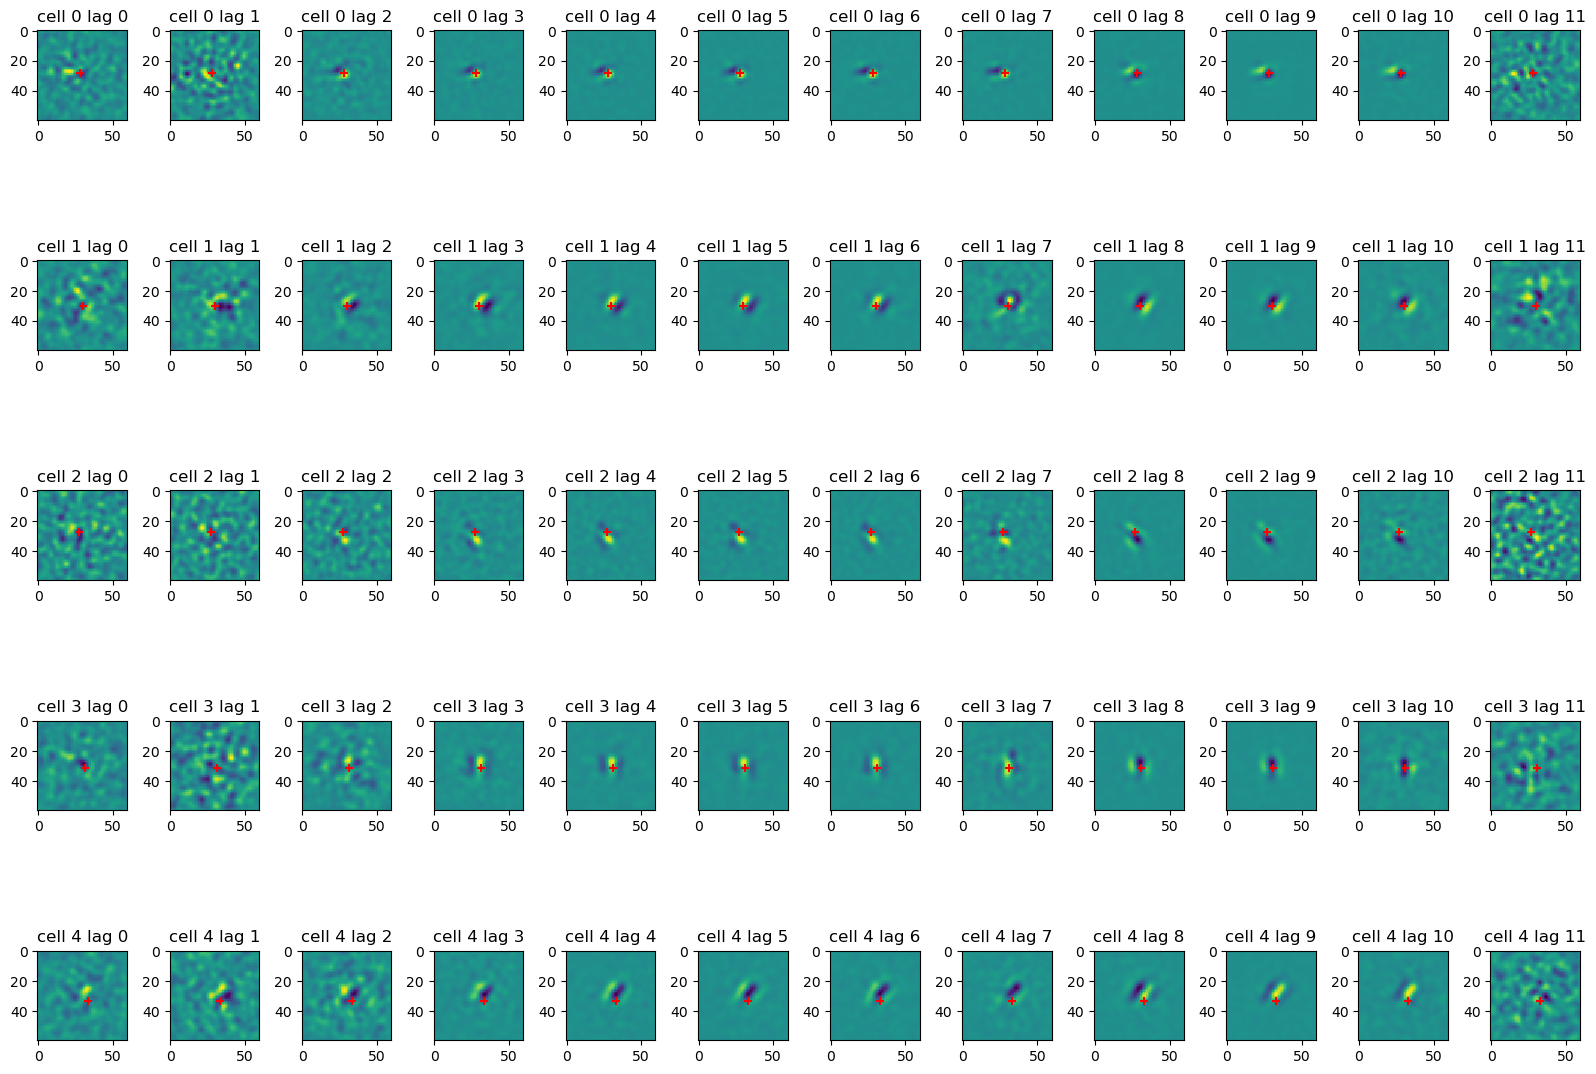

In [22]:
ss(5,12)
k = 1
for i in range(5):
    for j in range(12):
        plt.subplot(5,12,k)
        imagesc(w_glm[:,:,j,i])
        plt.scatter(pxl_x_pos[V1_idx][i],pxl_x_pos[V1_idx][i],c='r',s=40,marker='+')
        plt.title('cell '+str(i)+' lag '+str(j))
        k += 1
plt.tight_layout()
plt.show()

## CNN

In [9]:
Mreg = 0.1 # max

# LGN layer reg
Xreg0 = 1.0 # d2/dx
Creg0 = 1.0 # center
Treg = 1
#LGNwidth = LGN_filt.shape[0]

# Proj layer — still playing around with these
Xreg1 = 2.0 # d2/dx
Creg1 = 0.1 # center

ORIreg = 0 # chose orientation over spacial dim

# Define convolutional layers in the deep network
num_subs = [20] # num sub-units per layer
fws = [19]  # filter widths for each layer 
angles = [0,30,60,90,120,150] # [0,45,90,135]

# LGN layer
clayers = [STconvLayer.layer_dict( 
    input_dims=data.stim_dims, num_filters=2, bias=False, norm_type=1, 
    filter_dims=[1,19,19,num_lags], NLtype='lin', initialize_center=True,
    reg_vals={'d2t':Treg, 'edge_t': 100} )]

# Projection Layer
clayers.append(OriConvLayer.layer_dict(
    num_filters=num_subs[0], num_inh=num_subs[0]//4,
    bias=False, norm_type=1, initialize_center=True, window='hamming',
    filter_width=fws[0], NLtype='relu', reg_vals={'d2x':Xreg1, 'center': Creg1},
    angles=angles))

# Rest
#for ii in range(1,len(fws)):
#    clayers.append(OriConvLayer.layer_dict( 
#        num_filters=num_subs[ii], num_inh=num_subs[ii]//4, bias=False, norm_type=1, 
#        filter_width=fws[ii], NLtype='relu',
#        output_norm='batch', initialize_center=True, #window='hamming', 
#        angles=angles) )
        
scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold3d', xstim_n='stim', layer_list=clayers, scaffold_levels=[1], num_lags_out=len(angles))

readout_pars = ReadoutLayerQsample.layer_dict(
    num_filters=NC, NLtype='softplus', bias=True, pos_constraint=True,
    reg_vals={'gmax_t': ORIreg})

readout_net = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0],
    layer_list = [readout_pars], ffnet_type='readout')

cnn = NDN(ffnet_list = [scaffold_net, readout_net], loss_type='poisson')

#cnn.networks[0].layers[0].weight.data = LGN_filt.reshape((LGNwidth**2,2))  # this it the LGN from before
#cnn.networks[0].layers[0].set_parameters(val=True)

cnn.networks[1].layers[0].mu.data[:,0] = torch.tensor( mu0s[:,0], dtype=torch.float32)
cnn.networks[1].layers[0].mu.data[:,1] = torch.tensor( mu0s[:,1], dtype=torch.float32)
cnn.networks[1].layers[0].fit_mus(True)
cnn.block_sample = True
cnn.networks[1].list_parameters()

  ReadoutLayer: fitting mus
  Layer 0:
      weight: torch.Size([20, 1491])
      bias: torch.Size([1491])
      mu: torch.Size([1491, 2])
      sigma: torch.Size([1491, 1])
      Qmu: torch.Size([1491, 1])
      Qsigma: torch.Size([1491, 1])


In [10]:
# Adam Parameters
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=1,
    learning_rate=0.01, early_stopping_patience=6,
    optimize_graph=False, weight_decay = 0.2)
adam_pars['device'] = device

In [11]:
#cnn = cnn.to(device)
cnn.fit(data, **adam_pars, verbose=2)
#cnn = cnn.to(device0)

Model: M491_CsX_X

GPU Available: True, GPU Used: True


Validating ver=15: 100%|██████████████████████████████████████████████| 102/102 [00:14<00:00,  6.85it/s, val_loss=0.300386]

Early stopping
Done fitting
  Fit complete: 4185.597712755203 sec elapsed


In [ ]:
cnn.save_model_zip('models/0913_four_layer_model.ndn')

In [9]:
cnn = NDN.load_model_zip('models/0913_four_layer_model.ndn')
cnn.block_sample = True

In [10]:
cnn.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([4332, 2])
  Layer 1:
      weight: torch.Size([722, 8])
  Layer 2:
      weight: torch.Size([648, 8])
  Layer 3:
      weight: torch.Size([648, 8])
Network 1:
  Layer 0:
      weight: torch.Size([24, 1491])
      bias: torch.Size([1491])
      mu: torch.Size([1491, 2])
      sigma: torch.Size([1491, 1])
      Qmu: torch.Size([1491, 1])
      Qsigma: torch.Size([1491, 1])


In [11]:
LL = cnn.eval_models(data, data_inds=data.val_blks, device=device, batch_size=2, null_adjusted=True)
print('Log Likelyhood shape', LL.shape)

Eval models: 100%|█████████████████████████████████████████████████████████████████████████| 51/51 [00:49<00:00,  1.02it/s]

Log Likelyhood shape (1491,)


Median LL: 0.2970872


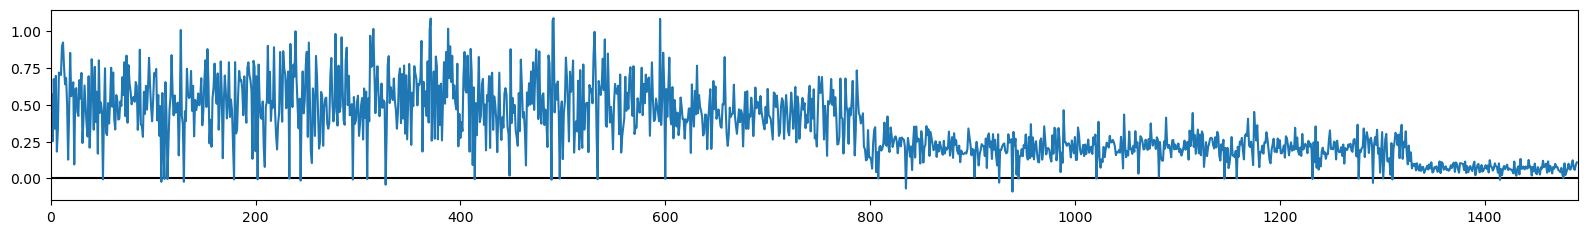

In [12]:
print('Median LL:', np.median(LL))
ss()
plt.plot([0,NC],[0,0], 'k')
plt.plot(LL)
plt.xlim([0,NC])
plt.show()

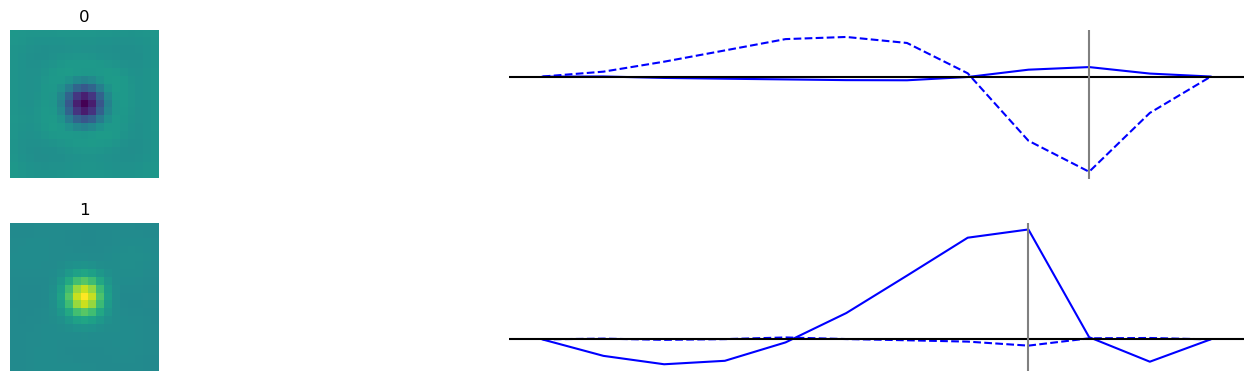

In [13]:
cnn.plot_filters()

In [14]:
ori_filters1 = cnn.get_weights(ffnet_target=0,layer_target=1)
ei_mask = deepcopy(cnn.networks[0].layers[1]._ei_mask)
print(ori_filters1.shape)
print(ei_mask.shape)

(2, 19, 19, 8)
torch.Size([48])


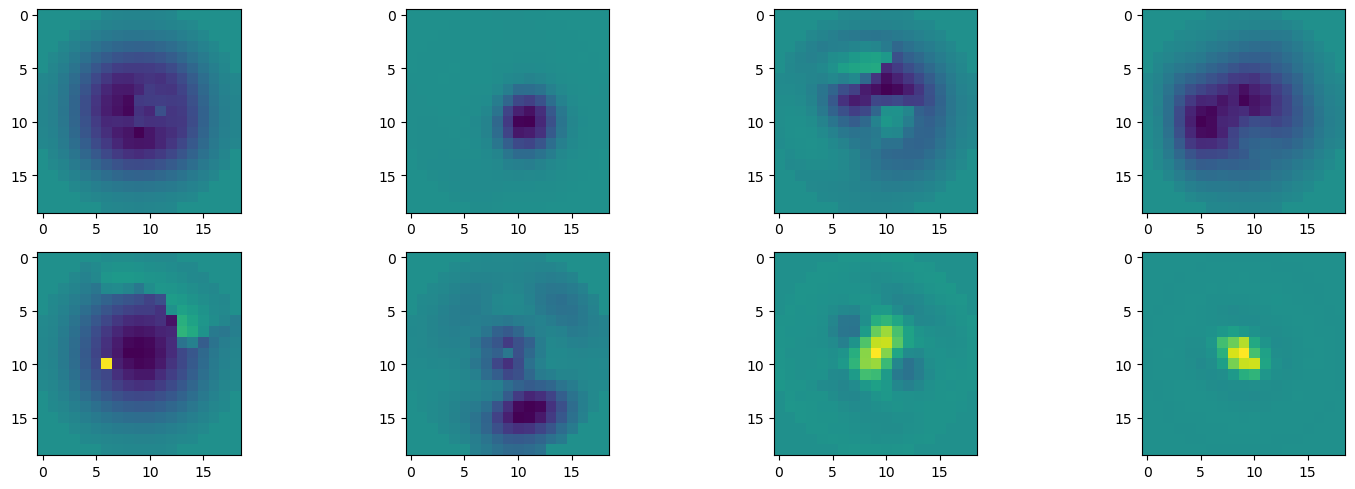

In [15]:
ss(2,4)
for i in range(8):
    plt.subplot(2,4,i+1)
    imagesc(ori_filters1[0,:,:,i])
plt.tight_layout()
plt.show()

In [16]:
ori_filters2 = cnn.get_weights(ffnet_target=0,layer_target=2)
print(ori_filters2.shape)

(8, 9, 9, 8)


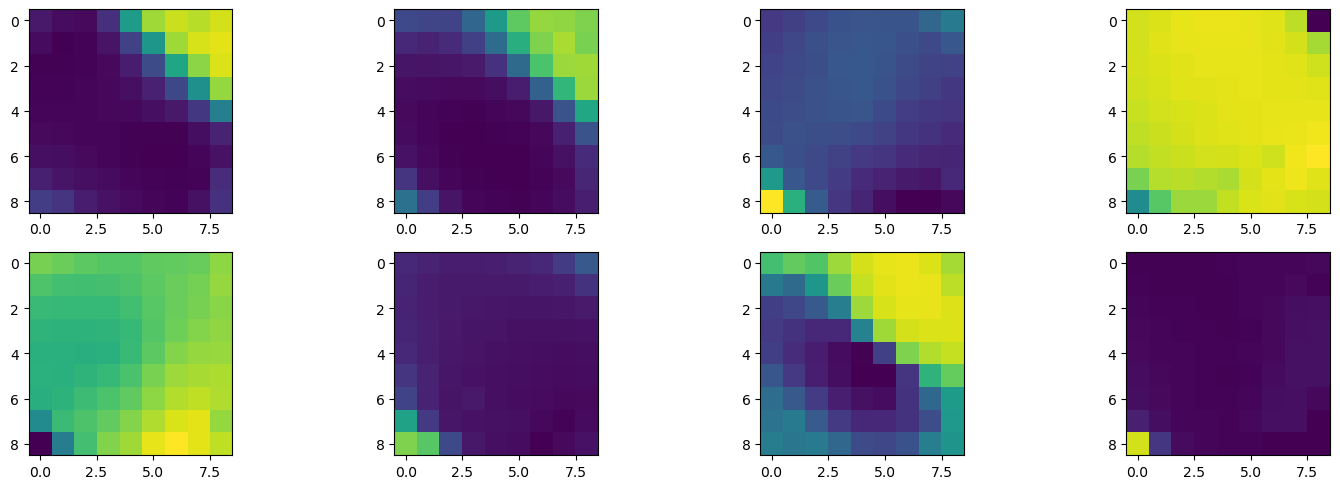

In [17]:
ss(2,4)
for i in range(8):
    plt.subplot(2,4,i+1)
    imagesc(ori_filters2[0,:,:,i])
plt.tight_layout()
plt.show()

In [18]:
sigma = deepcopy(cnn.networks[1].layers[0].sigma.data).numpy()

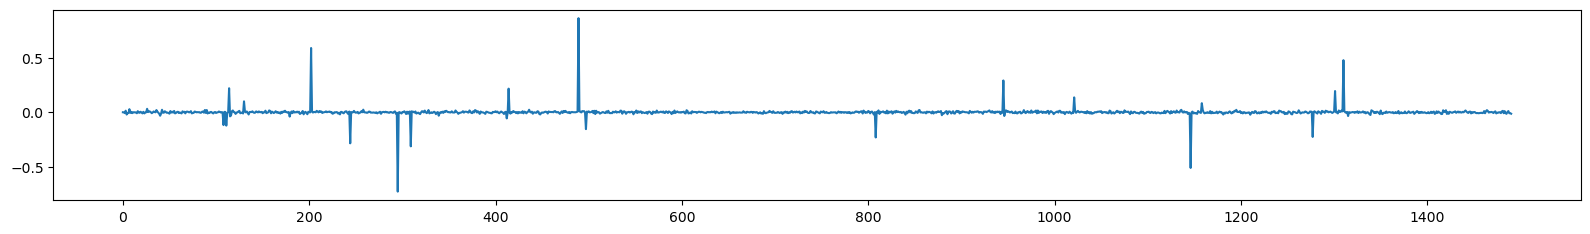

In [19]:
ss()
plt.plot(sigma)

In [20]:
val_blks = data.val_blks
print(val_blks.shape)

(102,)


In [21]:
cnn_preds = cnn(data[:10]).detach().cpu().numpy()

In [22]:
cnn_preds.shape

(10000, 1491)

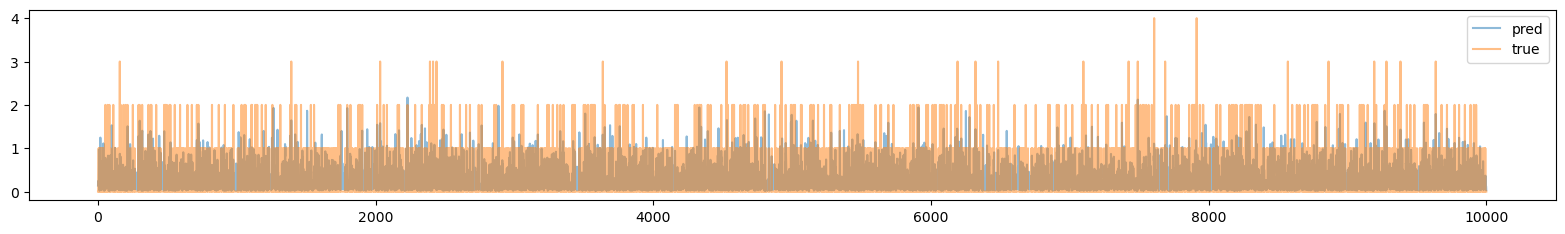

In [28]:
ss()
plt.plot(cnn_preds[:,0],label='pred',alpha=0.5)
plt.plot(data[:10]['robs'][:,0],label='true',alpha=0.5)
plt.legend()

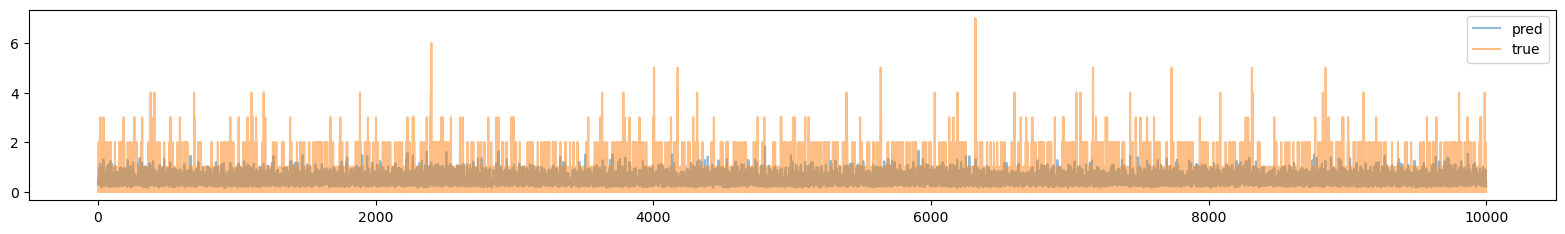

In [29]:
ss()
plt.plot(cnn_preds[:,-1],label='pred',alpha=0.5)
plt.plot(data[:10]['robs'][:,-1],label='true',alpha=0.5)
plt.legend()